In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
import torch
import numpy as np
import utils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%load_ext autoreload
np.random.seed(2) 
torch.manual_seed(2)

In [3]:
%autoreload

In [4]:
lcs = utils.get_data('../../datasets/ZTF_g', test_split=0.5)
net,optimizer,scheduler,lrs,args,epoch,losses = utils.load_checkpoint('../checkpoints/exp_26/ZTF_g1.131764531135559.h5', lcs.data_obj)


found 3408 for band='g'
max time:  1687.1367
created union_tp attribute of length 3500
dataset created, lcs.dataset.shape=(3083, 1, 1962, 3)
train size: 1541, valid size: 309, test size: 1542
=> loading checkpoint '../checkpoints/exp_26/ZTF_g1.131764531135559.h5'
Namespace(data_folder='/home2/fggr82/astr/hetast/src/datasets/ZTF_g', start_col=1, checkpoint=None, seed=2, device='mps', keep_missing=False, net='HeTVAE', mixing='concat', n_union_tp=3500, embed_time=128, num_heads=16, latent_dim=64, num_ref_points=16, rec_hidden=128, width=512, niters=6000, patience=1000, batch_size=2, k_iwae=1, lr=0.0001, beta1=0.9, beta2=0.999, scheduler=True, warmup=10, factor=0.9, lr_patience=40, threshold=0.01, dropout=0.0, inc_errors=False, frac=0.5, mse_weight=5.0, kl_annealing=True, kl_itrs=6000, n_cycles=32, start=0.0, stop=0.1, ratio=0.5, min_length=25, print_at=1, save_at=30, kl_zero=False, const_var=False, var_per_dim=False, num_resamples=0, is_bounded=False, std=0.1)


In [5]:
qzs,disc_path = utils.encode(lcs.data_obj['train_loader'], net, device='mps')
qzs.shape, disc_path.shape

  0%|                                                                                        | 0/771 [00:00<?, ?it/s]/Users/mattlowery/Desktop/Desko/code/astro/hetast/src/layers.py:83: UserWarning: MPS: no support for int64 repeats mask, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Repeat.mm:236.)
  scores = scores.unsqueeze(-1).repeat_interleave(dim, dim=-1)
100%|██████████████████████████████████████████████████████████████████████████████| 771/771 [00:10<00:00, 73.13it/s]


((1541, 2, 16, 64), (1541, 16, 64))

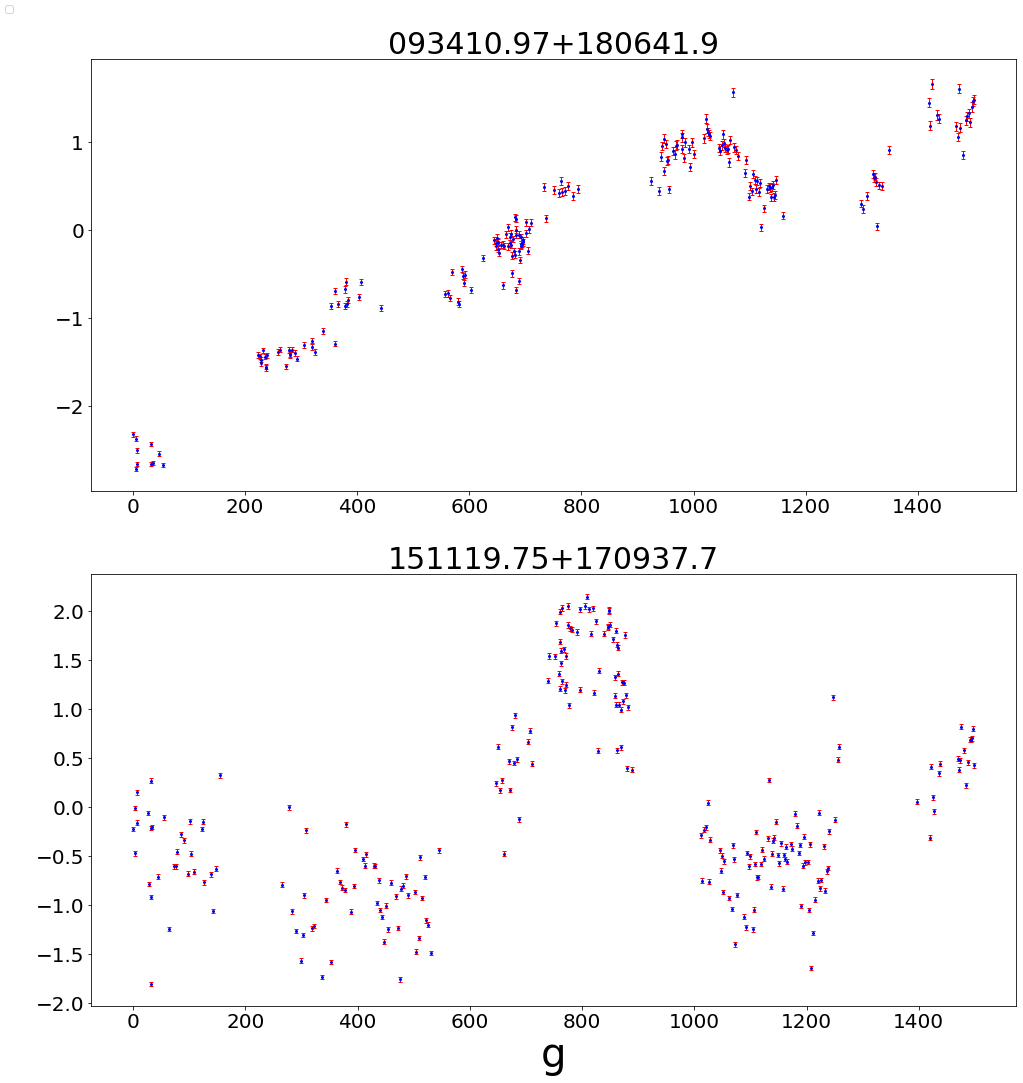

In [6]:
utils.preview_lcs(lcs, indexes=[440,345], figsize=(15,15), fs=30)




# Average the embeddings! 

In [10]:
i_1, i_2 = 440,345
dp_1, qz_1 = disc_path[i_1], qzs[i_1]
dp_2, qz_2 = disc_path[i_2], qzs[i_2]
avg_dp, avg_qz = (dp_1 + dp_2) / 2, (qz_1 + qz_2) / 2


In [11]:
lcs.valid_files_df.index[440], lcs.valid_files_df.index[345]

('093410.97+180641.9', '151119.75+170937.7')

# Take 10 samples from qz, decode separately, average them 

In [12]:
n_samples = 10
zs = avg_qz[0,:,:] + avg_qz[1,:,:] * np.random.randn(n_samples, avg_qz.shape[1], avg_qz.shape[2])
zs.shape

(10, 16, 64)

In [13]:
target_tp_unif = np.arange(0,1500,step=3, dtype=np.float32)
target_tp_both = np.union1d(lcs.dataset[i_1,0,:,0], lcs.dataset[i_2,0,:,0]).reshape((1,1,-1))

In [14]:
interps = np.array([utils.decode(net, z[np.newaxis],avg_dp[np.newaxis], target_tp_both) for z in zs])


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.58it/s]


In [15]:
t = interps[0,0,0,:,0]
y_avg = interps[:,:,:,:,1].mean(0)[0,0]
yerr_avg = interps[:,:,:,:,2].mean(0)[0,0]

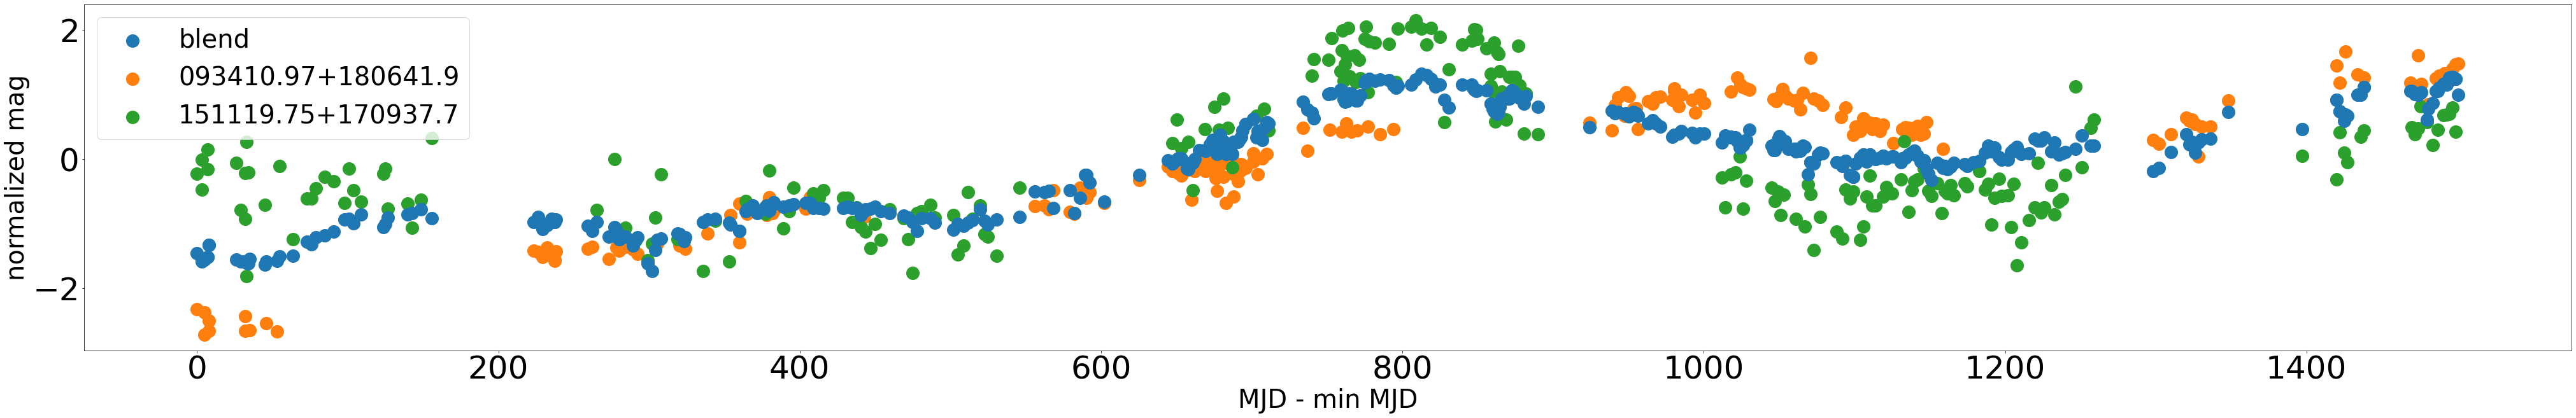

In [16]:
fs = 40
pts_1 = lcs.dataset[i_1,0,:,1].nonzero()
pts_2 = lcs.dataset[i_2,0,:,1].nonzero()
t_1,y_1 = lcs.dataset[i_1,0,pts_1,0][0],lcs.dataset[i_1,0,pts_1,1][0]
t_2,y_2 = lcs.dataset[i_2,0,pts_2,0][0],lcs.dataset[i_2,0,pts_2,1][0]

plt.rcParams['figure.figsize'] = (70,10)
plt.rcParams['xtick.labelsize'] = 50
plt.rcParams['ytick.labelsize'] = 50
plt.rcParams['lines.markersize'] = 40
plt.rcParams['scatter.marker'] = '.'
plt.scatter(t,y_avg, label='blend',zorder=100)
plt.scatter(t_1,y_1,label='093410.97+180641.9',)
plt.scatter(t_2,y_2,label='151119.75+170937.7')
plt.legend(loc='upper left',fontsize=fs)
plt.ylabel('normalized mag',fontsize=fs)
plt.xlabel('MJD - min MJD',fontsize=fs)
plt.savefig('../img/blend')

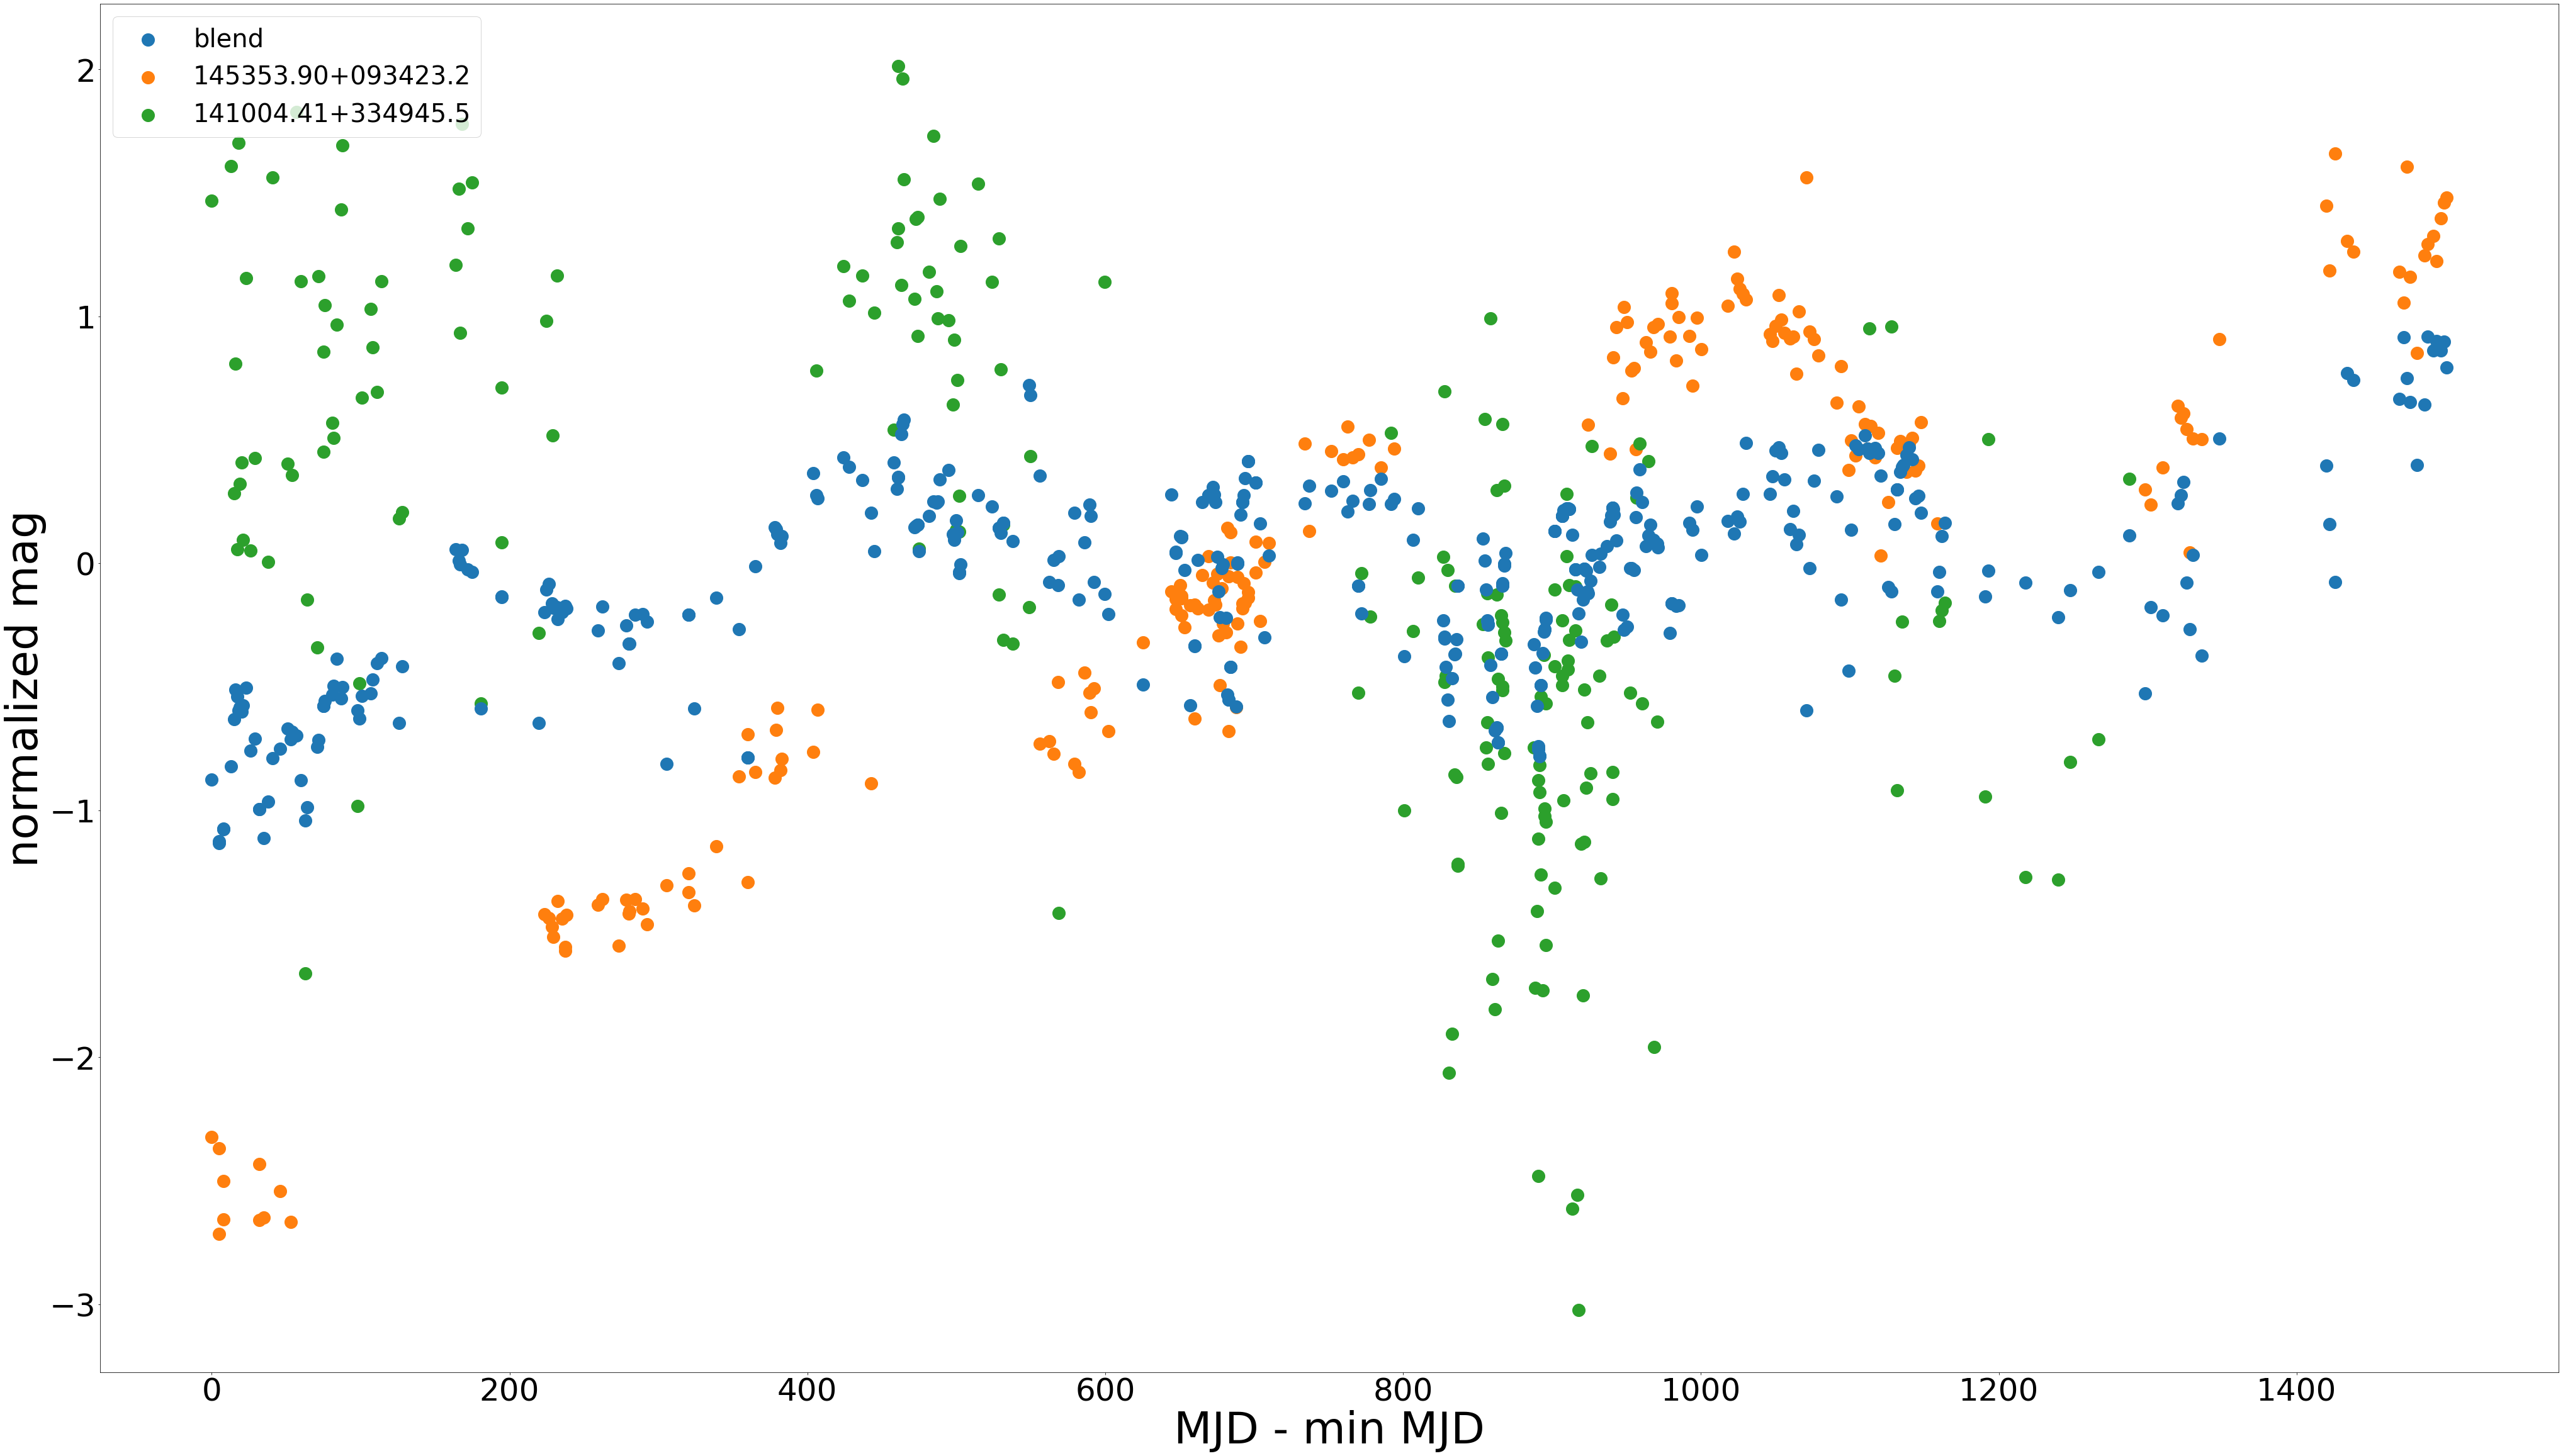

In [41]:
plt.rcParams['lines.marker'] = '.'
plt.rcParams['figure.figsize'] = (70,40)

plt.scatter(t,y_avg, label='blend',zorder=100)
plt.scatter(t_1,y_1,label='145353.90+093423.2',)

plt.scatter(t_2,y_2,label='141004.41+334945.5')
plt.legend(loc='upper left',fontsize=40)
plt.ylabel('normalized mag',fontsize=70)
plt.xlabel('MJD - min MJD',fontsize=70)
plt.savefig('../img/blend')